In [54]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Initialize a digraph based on monotype effectiveness
Let each of the 18 types be a node in a digraph, with initial weight 0 between all pairs of nodes. Then, for all pairs of types (U,V), adjust the weight of edge(U,V) as follows:

- If U is super-effective against V (x2), add 1 to weight
- If U is neutral against V (x1), do not change weight
- If U is not very effective against V (x1/2), subtract 1 from weight
- If U has no effect against V (x0), subtract 2 from weight

For example, the edge(Ghost,Psychic) has weight +1, since Ghost is super-effective against Psychic (+1), while Psychic is neutral against Ghost (+0). By iterating across all pairs, we can assign a score for how well each type counters another from both an offensive and defensive standpoint.

## 1.1 Converting table to graph and visualizing

In [3]:
''' Rows = offensve, Columns = Defense '''
df_effectiveness = pd.read_csv('data/monotypes.csv', index_col=0)
df_effectiveness.head()

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
Bug,1.0,2.0,1.0,1.0,0.5,0.5,0.5,0.5,0.5,2.0,1.0,1.0,1.0,0.5,2.0,1.0,0.5,1.0
Dark,1.0,0.5,1.0,1.0,0.5,0.5,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
Dragon,1.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0
Electric,1.0,1.0,0.5,0.5,1.0,1.0,1.0,2.0,1.0,0.5,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
Fairy,1.0,2.0,2.0,1.0,1.0,2.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,0.5,1.0


In [18]:
type_colors = {
    'Bug': '#A6B91A',
    'Dark': '#705746',
    'Dragon': '#6F35FC',
    'Electric': '#F7D02C',
    'Fairy': '#D685AD',
    'Fighting': '#C22E28',
    'Fire': '#EE8130',
    'Flying': '#A98FF3',
    'Ghost': '#735797',
    'Grass': '#7AC74C',
    'Ground': '#E2BF65',
    'Ice': '#96D9D6',
    'Normal': '#A8A77A',
    'Poison': '#A33EA1',
    'Psychic': '#F95587',
    'Rock': '#B6A136',
    'Steel': '#B7B7CE',
    'Water': '#6390F0'
}

In [30]:
G = nx.DiGraph()
ntypes = df_effectiveness.shape[0]
offensive_scores = {2.0:1, 1.0:0, 0.5:-1, 0.0:-2} # offensive multiplies to scores

node_colors = []
for ptype in df_effectiveness.index:
    G.add_node(ptype)
    node_colors.append(type_colors[ptype])

edge_widths = []
for i in range(ntypes):
    ptype_i = df_effectiveness.index[i]
    for j in range(i+1):
        ptype_j = df_effectiveness.index[j]
        i_to_j_score = offensive_scores[ df_effectiveness.iloc[i,j] ]
        j_to_i_score = offensive_scores[ df_effectiveness.iloc[j,i] ]
        score = i_to_j_score - j_to_i_score
        if score > 0:
            G.add_edge(ptype_i, ptype_j, weight=score)
            edge_widths.append(score)
        elif score < 0:
            G.add_edge(ptype_j, ptype_i, weight=-score)   
            edge_widths.append(-score)

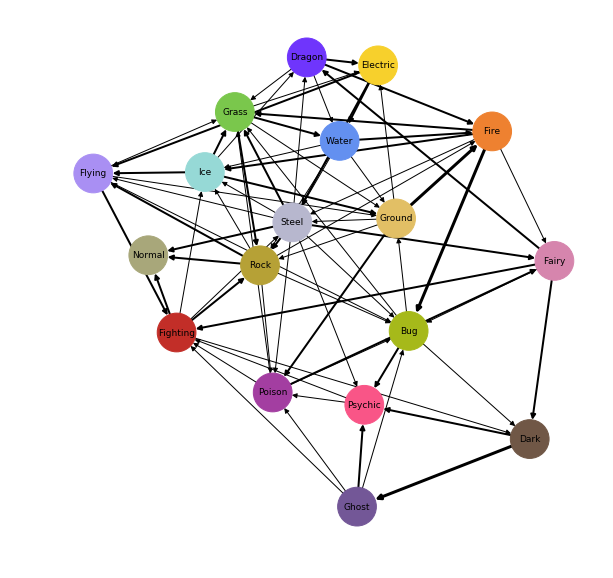

In [76]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
nx.draw_kamada_kawai(G, ax=ax, 
                     with_labels=True, font_size=9,
                     node_color=node_colors, node_size=1500,
                     width=edge_widths)

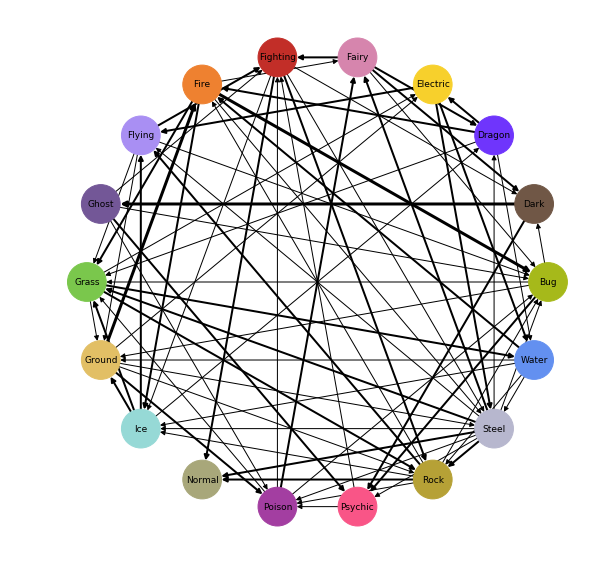

In [77]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
nx.draw_shell(G, ax=ax, 
             with_labels=True, font_size=9,
             node_color=node_colors, node_size=1500,
             width=edge_widths)

## 1.2 Rank types by basic degree metrics

In [53]:
degree_scores = {}
for ptype in G.nodes:
    indegree = G.in_degree(ptype) # total weight incoming, i.e. a type-vulnerability score
    outdegree = G.out_degree(ptype) # total weight outcoming, i.e. a type-effectiveness score
    netdegree = outdegree - indegree # net score
    degree_scores[ptype] = {'indegree':indegree, 'outdegree':outdegree, 'netdegree':netdegree}
    
df_degree = pd.DataFrame.from_dict(degree_scores).T 
df_degree = df_degree.reindex(columns=['indegree','outdegree', 'netdegree']) # re-order columns
df_degree

,indegree,outdegree,netdegree
Bug,7,4,-3
Dark,3,2,-1
Dragon,3,4,1
Electric,3,3,0
Fairy,3,4,1
Fighting,5,5,0
Fire,4,5,1
Flying,4,4,0
Ghost,1,4,3
Grass,7,4,-3


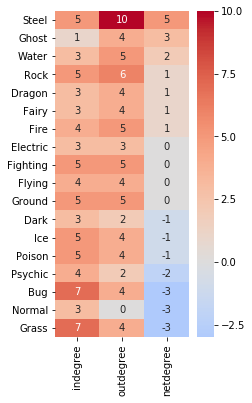

In [59]:
fig,ax = plt.subplots(1,1,figsize=(3,6))

sns.heatmap(df_degree.sort_values(by='netdegree', ascending=False), ax=ax,
            annot=True, fmt='d', cmap='coolwarm', center=0)

## 1.3 Rank types by eigencentrality

In [95]:
''' See https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html 
    Reversing graph to use out-edges to compute centralities'''
    
eigencentralities = nx.algorithms.eigenvector_centrality(G.reverse(), weight='weight')
df_eigencentralities = (pd.Series(eigencentralities))
df_eigencentralities = pd.DataFrame(df_eigencentralities).rename(columns={0:'eigencentrality'}) # convert Series -> DataFrame
df_eigencentralities

,eigencentrality
Bug,1.636139e-01
Dark,8.200991e-02
Dragon,1.685489e-01
Electric,1.998248e-01
Fairy,1.889410e-01
Fighting,1.988684e-01
Fire,3.389463e-01
Flying,3.023698e-01
Ghost,1.303317e-01
Grass,2.702330e-01


In [99]:
df_eigencentralities.values.mean()

0.2125962536391527

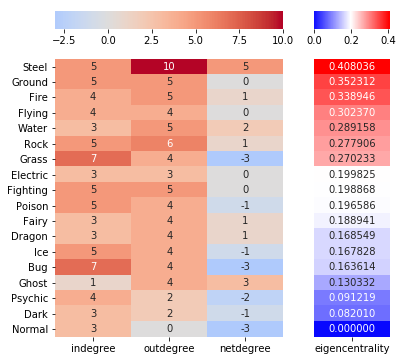

In [142]:
fig, axes = plt.subplots(2, 2, figsize=(6,6),
                         gridspec_kw={'height_ratios': [1,15], 'width_ratios': [15,5], 'wspace': 0.2})

eigenranking = df_eigencentralities.sort_values(by='eigencentrality', ascending=False).index

sns.heatmap(df_degree.loc[eigenranking,:], 
            ax=axes[1][0], cbar_ax=axes[0][0], cbar_kws={'orientation':'horizontal'},
            annot=True, fmt='d', cmap='coolwarm', center=0)
sns.heatmap(df_eigencentralities.sort_values(by='eigencentrality', ascending=False), yticklabels=False,
            ax=axes[1][1], cbar_ax=axes[0][1], cbar_kws={'orientation':'horizontal', 'ticks':[0.0,0.2,0.4]}, 
            annot=True, fmt='f', cmap='bwr', center=round(df_eigencentralities.values.mean(),1))